In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from supervenn import supervenn
import subprocess
from io import StringIO
import matplotlib.gridspec as gridspec

def figure_saver(fig, prefix, contexts=['paper'], formats=['.png', '.pdf', '.tiff']):
    
    for context in contexts:
        sns.set_context(context)
        for fformat in formats:
            fname = f"{prefix}_{context}{fformat}"
            fig.savefig(fname,  bbox_inches = "tight")
    
    sns.set_context('paper')

sns.set_context('paper')

def query_db(query, args=''):
    cmd = "mysql {} -e \"{}\"".format(args, query)
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if p.returncode > 0:
        print("Failed to query database with error:")
        print(p.stderr.decode())
    else:
        df = pd.read_csv(StringIO(p.stdout.decode()), sep='\t')
        return df

In [2]:
df = pd.read_csv('data/pan_master_gene_tbl.tsv', sep='\t')
df

,# userGeneName,gene_len,shortname,database,fa_header,fa_name,fa_descript,chosenSeq
0,pan_1,825,AMR_4817,amrfinderplus_genes,490423105|WP_004295324.1|NG_049639.1|1|1|blaOX...,490423105|WP_004295324.1|NG_049639.1|1|1|blaOX...,NG_049639.1:101-925,pan_1
1,pan_1,825,ARG_1063,argannot_genes,argannot~~~(Bla)blaOXA-347~~~JN086160:1583-240...,argannot~~~(Bla)blaOXA-347~~~JN086160:1583-2407,(Bla)blaOXA-347,pan_1
2,pan_1,825,CAR_637,CARD_AMR_genes,gb|JN086160.1|-|1582-2407|ARO:3001777|OXA-347 ...,gb|JN086160.1|-|1582-2407|ARO:3001777|OXA-347,[uncultured,pan_1
3,pan_1,825,FUN_126,functional_AMR_genes,beta-lactamase|JN086160.1|human_fecal_matter|AMX,beta-lactamase|JN086160.1|human_fecal_matter|AMX,NaN,pan_1
4,pan_1,825,MEG_4530,megares_genes,MEG_4750|Drugs|betalactams|Class_D_betalactama...,MEG_4750|Drugs|betalactams|Class_D_betalactama...,NaN,pan_1
...,...,...,...,...,...,...,...,...
30395,pan_9995,1272,FUN_758,functional_AMR_genes,tet-efflux|KJ694582.1|grassland_soil|TET,tet-efflux|KJ694582.1|grassland_soil|TET,NaN,pan_9995
30396,pan_9996,1275,FUN_684,functional_AMR_genes,tet-efflux|KJ694306.1|grassland_soil|TET,tet-efflux|KJ694306.1|grassland_soil|TET,NaN,pan_9996
30397,pan_9997,945,FUN_682,functional_AMR_genes,van-ligase|KJ694292.1|grassland_soil|CYC,van-ligase|KJ694292.1|grassland_soil|CYC,NaN,pan_10934
30398,pan_9998,495,FUN_739,functional_AMR_genes,dfr|KJ694518.1|grassland_soil|TMP,dfr|KJ694518.1|grassland_soil|TMP,NaN,pan_9998


In [3]:
sets = df.groupby('database')['# userGeneName'].unique().apply(set)

In [4]:
names = {
    'CARD_AMR_genes': 'CARD', 
    'CsabaPal_genes': 'CsabaPal',
    'amrfinderplus_genes': 'AMRFinderPlus', 
    'argannot_genes': 'ARGANNOT', 
    'functional_AMR_genes': 'ResFinderFG', 
    'megares_genes': 'MegaRes',
    'metalres_genes': 'MetalRes', 
    'resfinder_genes': 'ResFinder'
}

In [5]:
dfResFinder29 = pd.read_csv('data/ResFinder_hits.csv')
dfResFinder29SUM = dfResFinder29.groupby('run_accession').agg({'total_readfragmentCount': 'max', 'refSequence': 'nunique', 'fragmentCountAln': 'sum'})
dfResFinder29SUM['pct_resfinder'] = (dfResFinder29SUM['fragmentCountAln'] / dfResFinder29SUM['total_readfragmentCount'])*100

In [6]:
dfpanRes29 = pd.read_csv('data/panRes_hits.csv')
dfpanRes29SUM = dfpanRes29.groupby('run_accession').agg({'total_readfragmentCount': 'max', 'refSequence': 'nunique', 'fragmentCountAln': 'sum'})
dfpanRes29SUM['pct_panRes'] = (dfpanRes29SUM['fragmentCountAln'] / dfpanRes29SUM['total_readfragmentCount'])*100

In [7]:
dfMapped = dfpanRes29SUM.merge(dfResFinder29SUM, left_index=True, right_index=True, suffixes=['_panRes', '_resFinder'])

In [8]:
dfMapped['panRes_increased_references'] = dfMapped.refSequence_panRes - dfMapped.refSequence_resFinder

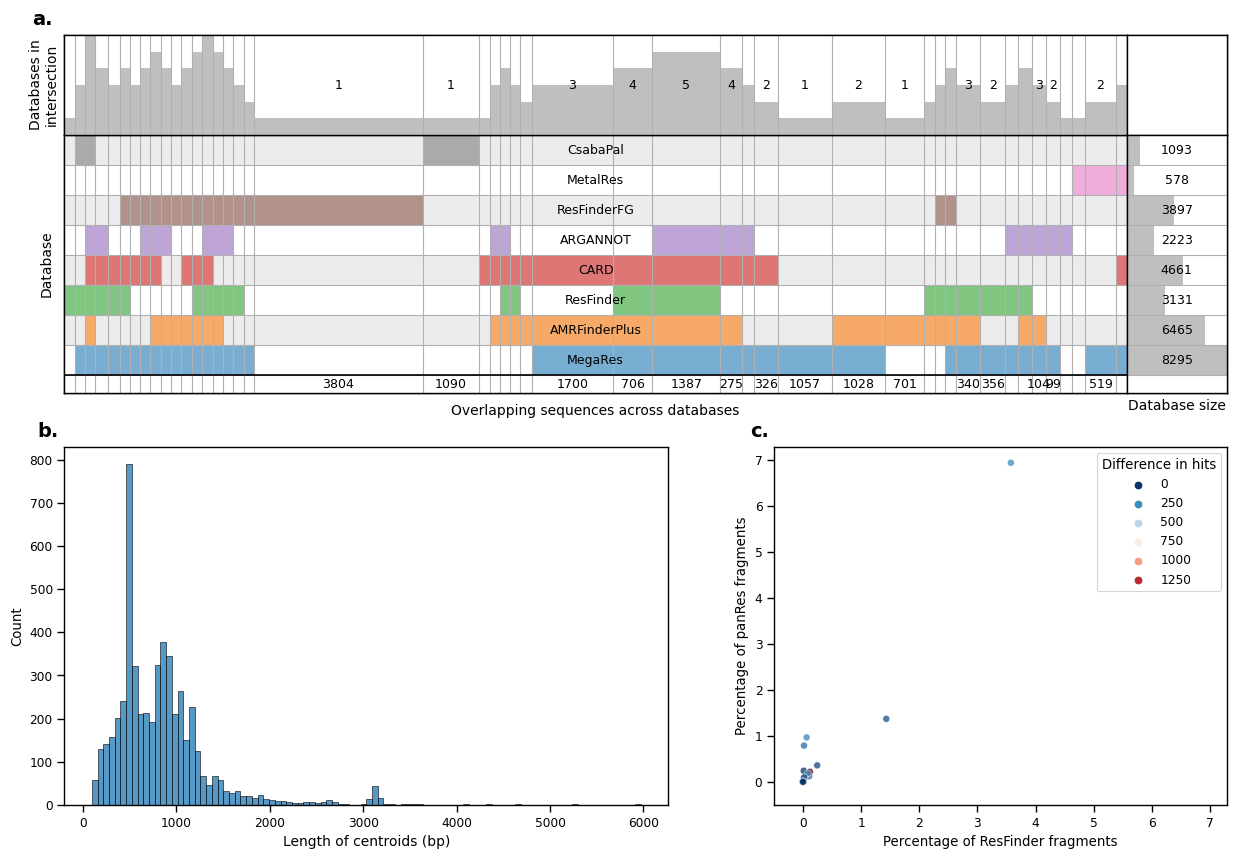

In [10]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(ncols=2, nrows=2, hspace=0.15, wspace=0.2, width_ratios=[1, .75])

ax_venn = fig.add_subplot(gs[0,:])
ax_hist = fig.add_subplot(gs[1,0])
ax_scatter = fig.add_subplot(gs[1,1])

sv = supervenn(sets.tolist(), sets.index.map(names).tolist(), 
               ax=ax_venn, 
               widths_minmax_ratio=0.06, 
               sets_ordering='chunk count', 
               min_width_for_annotation=99, 
               fontsize=9)

sns.histplot(
    data = df.loc[df['# userGeneName'] == df['chosenSeq']].drop_duplicates(subset=['# userGeneName']),
    x = 'gene_len',
    ax = ax_hist
)

sns.scatterplot(
    data = dfMapped,
    x = 'pct_resfinder',
    y = 'pct_panRes',
    alpha = .75,
    hue = 'panRes_increased_references',
    palette='RdBu_r',
    ax = ax_scatter,
    s = 25
)

xrange = ax_scatter.get_xlim()
yrange = ax_scatter.get_ylim()
ax_scatter.set_xlim(-.5, max([yrange[1], xrange[1]]))
ax_scatter.set_ylim(-.5, max([yrange[1], xrange[1]]))

ax_scatter.set_xlabel('Percentage of ResFinder fragments')
ax_scatter.set_ylabel('Percentage of panRes fragments')
ax_scatter.legend(title='Difference in hits')


sv.axes['main'].set_xlabel('Overlapping sequences across databases',fontsize=10)
sv.axes['main'].set_ylabel('Database', fontsize=10)

sv.axes['top_side_plot'].set_ylabel('Databases in\nintersection', fontsize=10)
sv.axes['right_side_plot'].set_xlabel('Database size', fontsize=10)

ax_hist.set_xlabel('Length of centroids (bp)',fontsize=10)

ax_venn.text(-0.01, 1.07, 'a.', transform=ax_venn.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
ax_hist.text(-0.01, 1.07, 'b.', transform=ax_hist.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
ax_scatter.text(-0.01, 1.07, 'c.', transform=ax_scatter.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

figure_saver(fig=fig, prefix='figures/panres')